# How to Think in JAX

JAX는 가속된 numerical code를 작성하기 위한 API를 제공한다. 그러나 JAX를 효과적으로 사용하기위해서 여러가지를 고려해야한다. 해당 문서는 JAX의 동작방식을 이해함으로써 효과적으로 사용할 수 있도록 작성되었다.

# JAX vs. NumPy

__Key Concepts:__

- JAX는 편의를 위해 NumPy와 비슷한 인터페이스를 제공한다.
- 덕 타이핑(duck-typing)을 통해, JAX arrays는 NumPy arrays로 따로 변환하지 않고 사용할 수 있다.
- NumPy arrays와 달리, JAX arrays는 항상 immutable 하다.

NumPy는 수치 데이터에 동작하기 위한 API를 제공한다. 편의를 위해 JAX는 `jax.numpy`를 제공한다. 이는 거의 numpy API와 동일하며 JAX에 쉽게 진입이 가능하도록한다. numpy에서 사용가능한 거의 모든 메소드를 `jax.numpy`를 통해 제공해주고있다.

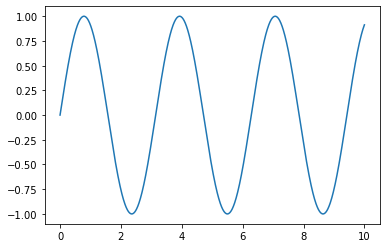

In [1]:
import matplotlib.pyplot as plt
import numpy as np

x_np = np.linspace(0, 10, 1000)
y_np = 2 * np.sin(x_np) * np.cos(x_np)
plt.plot(x_np, y_np)

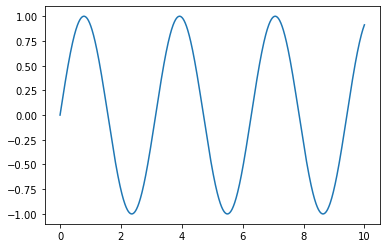

In [2]:
import jax.numpy as jnp

x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp)

단지 `np`를 `jnp`로 대체 했을뿐이며, 결과는 동일하게 나온다.

보시다시피, JAX arrays는 NumPy arrays 로서 직접 사용될 수 있다.

다음은 타입을 확인해본다.

In [4]:
type(x_np)

numpy.ndarray

In [5]:
type(x_jnp)

jax.interpreters.xla._DeviceArray

파이썬의 덕 타이핑 덕분에 JAX arrays와 NumPy arrays가 서로 교체가능하여 사용이 가능하다.

그러나 주요한 차이점은 존재하는데 그건 JAX arrays는 immutable 하다는 것이며, 이는 한번 만들어진 object는 바뀔 수 없다는 의미를 내포한다.

In [6]:
# NumPy : mutable arrays
x = np.arange(10)
x[0] = 10
print(x)

[10  1  2  3  4  5  6  7  8  9]


In [7]:
# JAX : immutable arrays
x = jnp.arange(10)
x[0] = 10

TypeError: '<class 'jax.interpreters.xla._DeviceArray'>' object does not support item assignment. JAX arrays are immutable; perhaps you want jax.ops.index_update or jax.ops.index_add instead?

개별 요소를 업데이트하려면, JAX의 indexed update syntax를 사용해야한다.

In [8]:
y = x.at[0].set(10) # copy 발생
print(x)
print(y)

[0 1 2 3 4 5 6 7 8 9]
[10  1  2  3  4  5  6  7  8  9]


# NumPy, lax & XLA: JAX API layering

__Key Concepts:__

- `jax.numpy`는 친숙한 인터페이스를 제공하는 high-level wrapper 이다.
- `jax.lax`는 더 엄격하고 강력한 lower-level API 이다.
- 모든 JAX의 연산은 XLA의 연산으로 구현되어있다.
    + XLA : the Accelerated Linear Algebra compiler

`jax.numpy`의 소스코드는 `jax.lax`의 함수들로 표현되어있다. `jax.lax`가 multi-dimensional arrays에 동작하는, 비교적 더 엄격하지만 상대적으로 더 파워풀한 API로 생각할 수 있다.

예를 들어, `jax.numpy`는 내부적으로 arguments가 mixed data types 사이에서 연산을 허용하는 반면, `jax.lax`는 그렇지 않다.

In [9]:
import jax.numpy as jnp
jnp.add(1, 1.0) # jax.numpy API implicitly promotes mixed types.

DeviceArray(2., dtype=float32)

In [10]:
from jax import lax
lax.add(1, 1.0) # jax.lax API requires explicit type promotion.

TypeError: add requires arguments to have the same dtypes, got int32, float32.

만일 `jax.lax`를 직접적으로 사용한다면, 명시적으로 다음과 같이 data type을 변경해야한다.

In [11]:
lax.add(jnp.float32(1), 1.0)

DeviceArray(2., dtype=float32)

이러한 엄격함에 따라, `jax.lax`는 또한 NumPy가 지원하는 것보다 더 일반적인 operations의 효율적인 API들을 제공한다.

예를 들어, 1차원 Convolution을 고려해보도록한다.

In [14]:
# jax.numpy
x = jnp.array([1, 2, 1])
y = jnp.ones(10)
jnp.convolve(x, y)

DeviceArray([1., 3., 4., 4., 4., 4., 4., 4., 4., 4., 3., 1.], dtype=float32)

In [15]:
# jax.lax
from jax import lax
result = lax.conv_general_dilated(
    x.reshape(1, 1, 3).astype(float), # note: explicit promotion
    y.reshape(1, 1, 10),
    window_strides=(1,),
    padding=[(len(y) - 1, len(y) - 1)] # equivalent of padding='full' in NumPy
)
result[0, 0]

DeviceArray([1., 3., 4., 4., 4., 4., 4., 4., 4., 4., 3., 1.], dtype=float32)

이는 deep neural netws에서 사용되는 convolutions 타입에 대해 효율적으로 설계된 batched convolution operation 이다. 훨씬 더 많은 설정이 필요하지만 NumPy에서 제공하는 convolution 보다 훨씬 더 유연하고 확장가능하다.

모든 `jax.lax` 연산들은 XLA내 연산을 파이썬으로 감싼것(Python wrappers)이다; 여기 예제에서 convolution 구현은 XLA의 [ConvWithGeneralPadding](https://www.tensorflow.org/xla/operation_semantics#convwithgeneralpadding_convolution)로 되어있다. 결국 JAX 연산은 이러한 기본적인 XLA 연산들로 표현이 되어있으며, 이는 JIT(Just-In-Time) compilation이 가능하게 합니다.

# To JIT or not to JIT

__Key Concepts:__

- 기본적으로 JAX는 순서대로 한번에 하나씩 연산들을 수행한다.
- JIT(Just-In-Time) compilation 데코레이터를 사용하면, 순서대로 나열된 연산들은 함께 최적화되고 한번에 실행될 수 있다.
- 모든 JAX 코드가 JIT compilation이 되지않는다. 이는 array shapes이 정적이고(static) compile 시 알려져야한다(known).

이전 섹션에서 언급했듯이 JAX 연산은 XLA 연산으로 구현되어있어 JIT compilation이 가능하다. 예를 들어, 2D 행렬의 행들을 정규화(normalize)하는 함수를 `jax.numpy` 연산들로 표현한다고 하자.

In [16]:
import jax.numpy as jnp

def norm(X):
    X = X - X.mean(0)
    return X / X.std(0)

JIT compile을 수행하려면 `jax.jit`를 이용할 수 있다.

In [17]:
from jax import jit
norm_compiled = jit(norm)

이 함수는 표준 부동소수점 정확도까지 원본과 같은 결과를 낸다.

In [20]:
np.random.seed(1701)
X = jnp.array(np.random.rand(10000, 10))
np.allclose(norm(X), norm_compiled(X), atol=1E-6)

True

그러나 compilation 덕분에 실행시간은 JIT 컴파일된 경우에 훨씬 더 빨라질 수 있다. `block_until_ready()`의 사용은 JAX's [asyhronous dispatch](https://jax.readthedocs.io/en/latest/async_dispatch.html)를 참고하세요.

In [19]:
%timeit norm(X).block_until_ready()
%timeit norm_compiled(X).block_until_ready()

2.54 ms ± 85.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
218 µs ± 3.47 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


이는 `jax.jit`가 제한적임을 의미한다: 특히, 모든 arrays가 static shapes를 가져야한다. 즉, 몇몇 JAX 연산들은 JIT compilation을 같이 사용할 수 없음을 의미한다.

예를 들어, 아래와 같은 operation은 op-by-op 모드로 실행된다.

In [21]:
def get_negatives(x):
    return x[x < 0]

x = jnp.array(np.random.randn(10))
get_negatives(x)

DeviceArray([-0.10570311, -0.59403396, -0.8680282 , -0.23489487], dtype=float32)

하지만 jit mode에서 해당 함수를 실행하려고하면 에러가 발생한다.

In [22]:
jit(get_negatives)(x)

IndexError: Array boolean indices must be concrete.

이는 함수를 jit 컴파일 시 array의 shape을 알 수 없기 때문이다: output의 크기는 input array에 의존하기 때문에 JIT를 같이 사용할 수 없다.

# JIT mechanics: tracing and static variables

__Key Concepts:__

- JIT 및 기타 다른 JAX 변환은 함수를 추적함으로써(by tracing) 특정 shape과 type의 inputs에 미치는 영향을 판별하는 방식으로 동작한다.
- 추적당하기 싫은 Variables는 static으로 막을 수 있다.

`jax.jit`를 효과적으로 사용하기 위해서는, 어떻게 동작하는지 알아야 도움이 된다.

`print()`를 JIT-compiled 함수에 넣은 후 함수를 호출해본다:

In [30]:
@jit
def f(x, y):
    print("Running f():")
    print(f"    x = {x}")
    print(f"    y = {y}")
    result = jnp.dot(x+1, y+1)
    print(f"    result = {result}")
    return result

x = np.random.randn(3, 4)
y = np.random.randn(4)
f(x, y)

Running f():
    x = Traced<ShapedArray(float32[3,4])>with<DynamicJaxprTrace(level=0/1)>
    y = Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=0/1)>
    result = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=0/1)>


DeviceArray([ 4.7572737, 12.42463  ,  5.556969 ], dtype=float32)

위 결과를 보면, 함수내 print에 의해 출력된 결과는 값자체가 아닌 tracer objects가 나온 거라고 알 수 있다.

이는 tracer objects는 `jax.jit`가 함수에서 지정된 연산 순서를 추출하는데 사용된다. 기본적인 tracers는 arrays의 shape과 타입을 인코딩하는 독립형이지만 값에는 영향을 주지 않는다.

이렇게 기록된 계산 시퀀스는 파이썬 코드 재실행없이 XLA 내부에서 효율적으로 같은 shape과 타입을 가진 새로운 inputs에 적용될 수 있다.

매칭한 inputs에 컴파일된 함수를 다시 불러올때, 다시 컴파일하지 않아도되며 어떤 것도 출력되지 않는데 이는 결과값이 파이썬이 아닌 컴파일된 XLA에서 계산됐기 때문이다.

In [31]:
x2 = np.random.randn(3, 4)
y2 = np.random.randn(4)
f(x2, y2)

Buffer([6.0429235, 3.9097326, 1.4635869], dtype=float32)

추출된 연산 시퀀스는 JAX expression로 인코딩되어있다. 이를 짧게 표현하여 jaxpr 라고 부른다. jaxpr은 `jax.make_jaxpr` 변환을 사용하여 확인할 수 있다.

In [35]:
from jax import make_jaxpr

def f(x, y):
    return jnp.dot(x + 1, y + 1)

make_jaxpr(f)(x, y)

{ lambda  ; a b.
  let c = add a 1.0
      d = add b 1.0
      e = dot_general[ dimension_numbers=(((1,), (0,)), ((), ()))
                       precision=None
                       preferred_element_type=None ] c d
  in (e,) }

아래의 경우 array의 정보없이 JIT 컴파일이 수행됐기 때문에, 함수의 제어 흐름문은 추적된(traced) 값에 의존할 수 없다.

In [27]:
@jit
def f(x, neg):
    return -x if neg else x

f(1, True)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected.

The problem arose with the `bool` function. 

While tracing the function f at <ipython-input-27-327480aab76f>:1, this concrete value was not available in Python because it depends on the value of the arguments to f at <ipython-input-27-327480aab76f>:1 at flattened positions [1], and the computation of these values is being staged out (that is, delayed rather than executed eagerly).

You can use transformation parameters such as `static_argnums` for `jit` to avoid tracing particular arguments of transformed functions, though at the cost of more recompiles.

See https://jax.readthedocs.io/en/latest/faq.html#abstract-tracer-value-encountered-where-concrete-value-is-expected-error for more information.

Encountered tracer value: Traced<ShapedArray(bool[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>

추적하지 않으려는 변수가 있는 경우 JIT 컴파일을 위해 정적 변수로 표시할 수 있다.

In [36]:
from functools import partial

@partial(jit, static_argnums=(1,))
def f(x, neg):
  return -x if neg else x

f(1, True)

DeviceArray(-1, dtype=int32)

다른 static argument를 컴파일된 함수에 넣어 호출하면 다시 컴파일하여 여전히 기대되는대로 동작한다.

In [38]:
f(1, False)

DeviceArray(1, dtype=int32)

결론적으로 어떤 값과 연산이 static 할 것이고 추적될 것인지 이해하는 것이 `jax.jit`를 효과적으로 사용하는데 주요한 부분이다.

# Static vs Traced Operations

__Key Concepts:__

- 값이 static 하거나 traced 한것처럼 연산들도 static 하거나 traced 될 수 있다.
- Static 연산들은 파이썬에서 컴파일 시 평가된다; Traced 연산들은 런타임에서 컴파일 및 평가가 이루어진다.
- Static 연산에는 `numpy`를 사용하고, traced 연산에는 `jax.numpy`를 사용하라고 한다.

static과 traced 값 사이의 차이점이 있기 때문에 어떻게 static 값을 static하게 유지할지 생각해보는 것이 중요하다.

아래 함수를 보도록한다.

In [40]:
import jax.numpy as jnp
from jax import jit

@jit
def f(x):
    return x.reshape(jnp.array(x.shape).prod())

x = jnp.ones((2,3))
f(x)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected.

The error arose in jax.numpy.reshape.

While tracing the function f at <ipython-input-40-0971c9a93fd4>:4, this value became a tracer due to JAX operations on these lines:

  operation c:int32[] = reduce_prod[ axes=(0,) ] b:int32[2]
    from line <ipython-input-40-0971c9a93fd4>:6 (f)

See https://jax.readthedocs.io/en/latest/faq.html#abstract-tracer-value-encountered-where-concrete-value-is-expected-error for more information.

Encountered tracer value: Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=0/1)>

`jax.numpy.reshape`에서 tracer를 찾아서 에러를 찾아냈다. 이번에는 `print` statements를 함수에 추가하여 왜 이런 일이 발생하는지 이해해보도록 한다.

In [41]:
@jit
def f(x):
    print(f"x = {x}")
    print(f"x.shape = {x.shape}")
    print(f"jnp.array(x.shape).prod() = {jnp.array(x.shape).prod()}")

f(x)

x = Traced<ShapedArray(float32[2,3])>with<DynamicJaxprTrace(level=0/1)>
x.shape = (2, 3)
jnp.array(x.shape).prod() = Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=0/1)>


비록 `x`가 traced 하다고해도, `x.shape`는 static 값이라는 점에 주목해보자. 

`jnp.array`와 `jnp.prod`를 이 static 값에 사용하면 다시 traced 값으로 변한다. 

그래서 `reshape()`과 같이 static 값을 input으로 받는 함수에서 에러가 발생하는 것이다.

유용한 패턴은 static 해야하는 연산에 대해 `numpy`를 사용하는 것이다. 그리고 traced 해야하는 연산에 대해서 `jax.numpy`를 사용하는 것이다.

이전에 실패했던 함수에 대해서는 아래와 같이 다시 작성할 수 있다.

In [43]:
from jax import jit
import jax.numpy as jnp
import numpy as np

@jit
def f(x):
    return x.reshape((np.prod(x.shape),))

f(x)

DeviceArray([1., 1., 1., 1., 1., 1.], dtype=float32)

이러한 이유로 JAX 프로그램의 표준 규칙은 numpy를 np로 가져오고 jax.numpy를 jnp로 가져와서 operation이 static 문제에서 수행되는지 (컴파일 시간에 한번 numpy를 사용) 또는 traced 문제에서 수행되는지 (jax.numpy를 통해 런타임 때 최적화) 여부를 보다 세밀하게 제어할 수 있도록 두 인터페이스를 사용할 수 있도록 했다.

